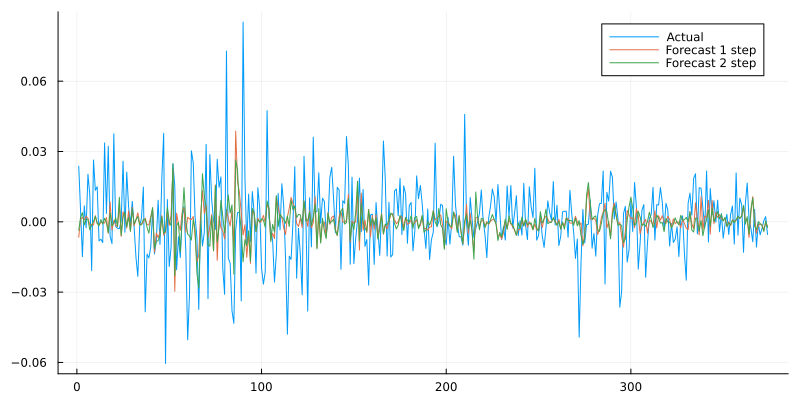

Any[0.00029517975735240574, 0.0002984869485492653]


In [1]:
using DataFrames, Random, Statistics, Plots
using AirBorne.ETL.YFinance: get_interday_data
using RollingFunctions
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using Dates: DateTime, datetime2unix

function regress(data, lookback=1, lookahead=1)
    num_samples = length(data) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (data[i:i+lookback-1]) 
        outputs[i,:] = data[i+lookback:i+lookback+lookahead-1]
    end
    params = inputs \ outputs
    return params
end

function run_regression(data; lookback=1, lookahead=1, reparameterise_window=0)
    step_map = Dict()
    step_error = []
    load_idx = max(lookback, reparameterise_window, round(Int, length(data) / 2))
    loading_data = data[1:load_idx]
    running_data = data[load_idx+1:end]

    function run_func(x)
        all_data = [loading_data; x]
        if reparameterise_window != 0
            all_data = all_data[end-reparameterise_window+1:end]
        end
        multiplier = regress(all_data, lookback, lookahead)
        return all_data[end-lookback+1:end]' * multiplier
    end

    if reparameterise_window == 0
        reparameterise_window = length(running_data)
    end
    forecast = running(run_func, running_data, reparameterise_window)
    # println(forecast)
    for i in 1:lookahead
        if i == 1
            fill_data = []
        else
            fill_data = running_data[2:i]
        end
        fill_data = running_data[1:i]
        step_map[i] = [fill_data;collect(Iterators.flatten(f[i] for f in forecast))][1:length(running_data)]

        e = step_map[i][i+1:end] .- running_data[i+1:end]
        push!(step_error, mean((e).^2))
    end

    step_plot = plot(running_data[lookahead+1:end], label="Actual", size=(800, 400))
    for i in 1:lookahead
        plot!(step_map[i][lookahead+1:end], label="Forecast $i step")
    end
    return step_plot, step_error
end

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2021-01-01"), unix("2024-01-01"))
returns = diff(log.(aapl.close))

p, error = run_regression(returns; lookback=5, lookahead=2, reparameterise_window=50)
display(p)
println(error)


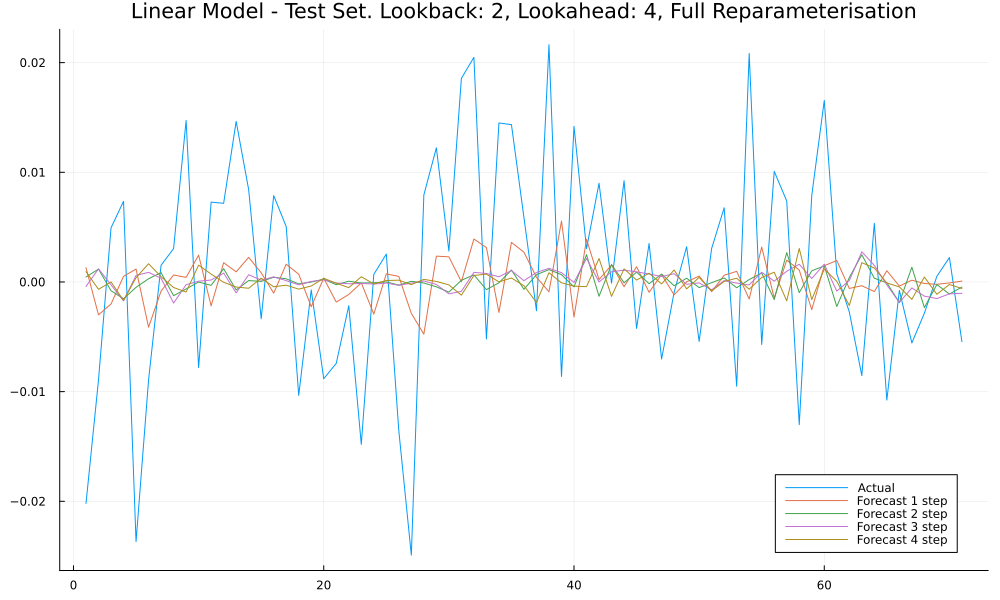

MADS Run Summary
-------------------------------------------------
Feasible Solution           [2.0, 4.0, 0.0]
Feasible Cost               0.0004267357258487106
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  58
Function Evaluations        15
Cache hits                  92
Optimization Status         Mesh Precision limit

Runtime                     0.8810529708862305
Search Time                 1.1327000000000004e-5
Poll Time                   0.008452833
Blackbox Evaluation Time    0.7430079960000001
Error with no window = 0.00010581098836637986


"/Users/sherifagbabiaka/Documents/uni-4/FYP/fyp_repo/linear_plots/linear_fixed_reparam/2_4_0_TEST.svg"

In [16]:
using DirectSearch

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2021-01-01"), unix("2024-01-01"))
returns = diff(log.(aapl.close))
train_idx = round(Int, length(returns) * 0.8)
train, test = returns[1:train_idx], returns[train_idx+1:end]

function objective(x)
    params = round.(Int, x)
    obj_plot, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    plot!(obj_plot; title="Linear Model - Train Set. Lookback: $(params[1]), Lookahead: $(params[2]), Full Reparameterisation", size=(1000, 600))
    savefig(obj_plot, "linear_plots/linear_fixed_reparam/$(params[1])_$(params[2])_$(params[3]).svg")
    return mean(errors)
end

# Optimising with a variable reparameterisation window

# problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 50])
# valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 < x[3] < round(Int, length(test) / 2))
# AddExtremeConstraint(problem, valcond)
# Optimize!(problem)

# optimal = round.(Int, problem.x)

# opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
# println("Error with window = $(mean(error_window))")
# plot!(opt_plot; title="Linear Model - Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Reparameterisation Window: $(optimal[3])", size=(1000, 600))
# display(opt_plot)
# savefig(opt_plot, "linear_plots/linear_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_TEST.svg")

# Optimising with full reparameterisation window

problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 1, 0])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 == x[3])
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_no_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
println("Error with no window = $(mean(error_no_window))")
plot!(opt_plot; title="Linear Model - Test Set. Lookback: $(optimal[1]), Lookahead: $(optimal[2]), Full Reparameterisation", size=(1000, 600))
display(opt_plot)

savefig(opt_plot, "linear_plots/linear_fixed_reparam/$(optimal[1])_$(optimal[2])_$(optimal[3])_TEST.svg")


# Using 5 minute intervals

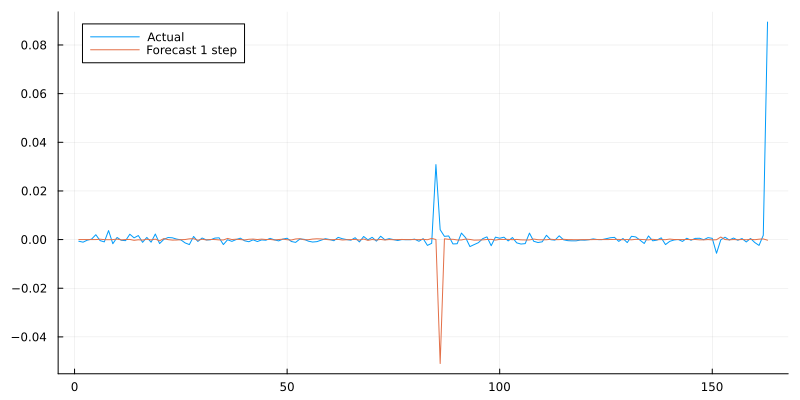

In [36]:
using AirBorne.ETL.YFinance: get_chart_data, parse_intraday_raw_data

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = parse_intraday_raw_data(get_chart_data("AAPL", unix("2024-04-01"), unix("2024-04-30"), "5m"))

returns = diff(log.(aapl.close))
println(returns)

train_idx = round(Int, length(returns) * 0.8)
train, test = returns[1:train_idx], returns[train_idx+1:end]

function objective(x)
    params = round.(Int, x)
    _, errors = run_regression(train; lookback=params[1], lookahead=params[2], reparameterise_window=params[3])
    # println("params: $(params), error: $(mean(errors))")
    return mean(errors)
end

problem = DSProblem(3, objective=objective, granularity=[1, 1, 1], initial_point=[5, 4, 50])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && (0 < x[3] < round(Int, length(test) / 2))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

optimal = round.(Int, problem.x)

opt_plot, error_window = run_regression(test; lookback=optimal[1], lookahead=optimal[2], reparameterise_window=optimal[3])
println("Error with window = $(mean(error_window))")
display(opt_plot)
